# 1. Veri Setini Y√ºkleme ve Ke≈üfetme

**1.1 K√ºt√ºphaneleri ƒ∞√ße Aktarma**

In [2]:
!pip install -q "numpy==1.26.4" "pandas==2.2.2"


   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13.0/13.0 MB 85.8 MB/s eta 0:00:00:00:01:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.5.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
google-colab 1.0.0 requires google-auth==2.38.0, but you have google-auth 2.40.3 which is incompatible.
google-colab 1.0.0 requires notebook==6.5.7, but you have notebook 6.5.4 which is incompatible.
google-colab 1.0.0 requires requests==2.32.3, but you have requests 2.32.4 which is incompatible.
google-colab 1.0.0 requires tornado==6.4.2, but you have tornado

In [5]:
import os, random
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
import numpy as np, pandas as pd
print("numpy:", np.__version__)
print("pandas:", pd.__version__)


numpy: 1.26.4
pandas: 2.2.2


**1.2 Dataset Yollarƒ±**

In [6]:
from pathlib import Path

DATA_DIR = Path("/kaggle/input/the-oxfordiiit-pet-dataset")

# dikkat: i√ß i√ße klas√∂r var
IMG_DIR = DATA_DIR / "images" / "images"
ANN_DIR = DATA_DIR / "annotations" / "annotations"

print("IMG klas√∂r√º:", IMG_DIR.exists(), "->", len(list(IMG_DIR.glob("*.jpg"))))
print("ANN klas√∂r√º:", ANN_DIR.exists())
print("ƒ∞√ßindekiler:", [f.name for f in ANN_DIR.iterdir()][:10])


IMG klas√∂r√º: True -> 7390
ANN klas√∂r√º: True
ƒ∞√ßindekiler: ['._trimaps', 'xmls', 'README', 'test.txt', 'trainval.txt', 'list.txt', 'trimaps']


**1.3 Dosya ve Etiket Dosyalarƒ±nƒ± Kontrol**

In [7]:
all_imgs = sorted([p for p in IMG_DIR.iterdir() if p.suffix.lower()==".jpg"])
print("Toplam resim sayƒ±sƒ±:", len(all_imgs))
print("√ñrnek dosyalar:", [p.name for p in all_imgs[:10]])

for f in ["list.txt", "trainval.txt", "test.txt"]:
    print(f, "->", (ANN_DIR / f).exists())


Toplam resim sayƒ±sƒ±: 7390
√ñrnek dosyalar: ['Abyssinian_1.jpg', 'Abyssinian_10.jpg', 'Abyssinian_100.jpg', 'Abyssinian_101.jpg', 'Abyssinian_102.jpg', 'Abyssinian_103.jpg', 'Abyssinian_104.jpg', 'Abyssinian_105.jpg', 'Abyssinian_106.jpg', 'Abyssinian_107.jpg']
list.txt -> True
trainval.txt -> True
test.txt -> True


**1.4 Rastgele G√∂rselleri G√∂ster**

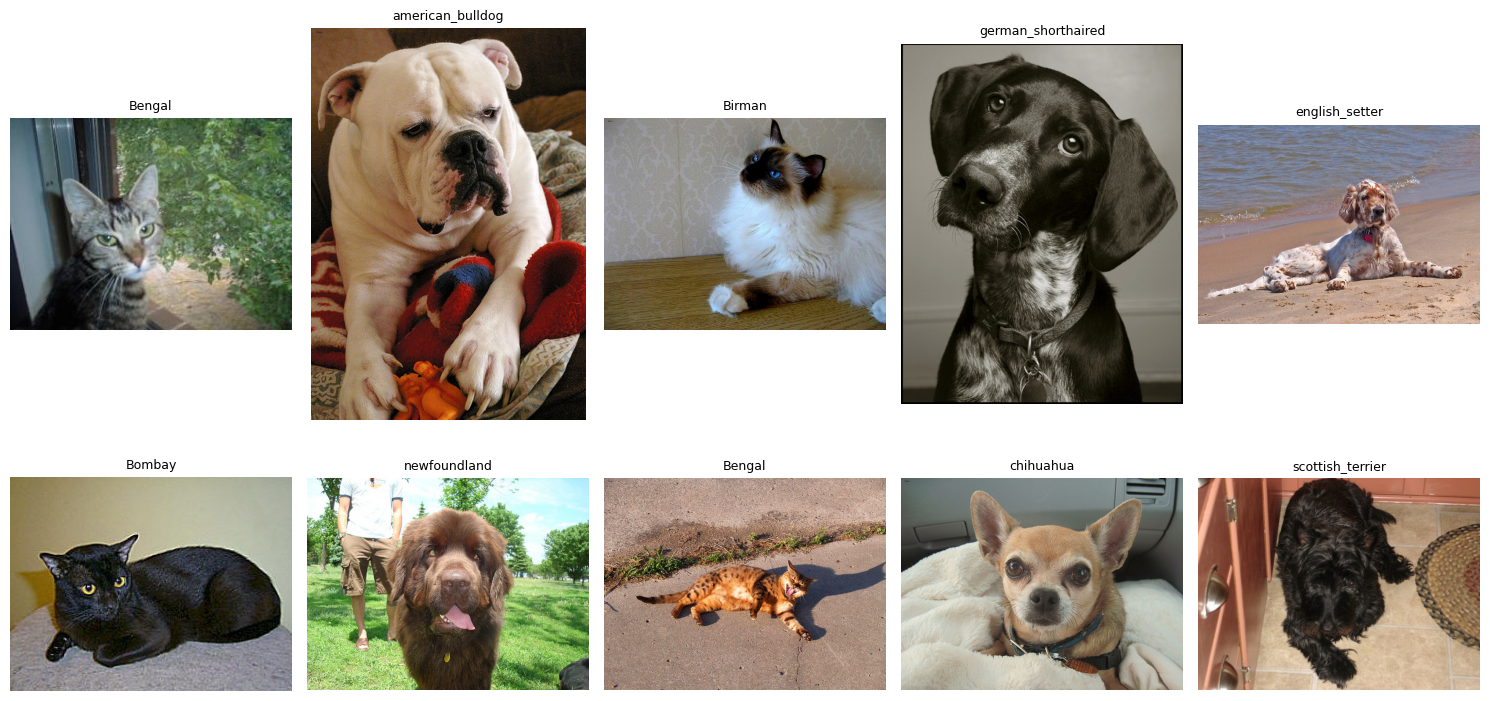

In [8]:
def infer_class_from_filename(fname: str):
    return fname.rsplit("_", 1)[0]

sample_imgs = random.sample(all_imgs, 10)

plt.figure(figsize=(15, 8))
for i, p in enumerate(sample_imgs, 1):
    img = Image.open(p).convert("RGB")
    plt.subplot(2, 5, i)
    plt.imshow(img)
    plt.title(infer_class_from_filename(p.name), fontsize=9)
    plt.axis("off")
plt.tight_layout()
plt.show()


**1.5 ƒ∞lk Ke≈üif**

In [9]:
names = [infer_class_from_filename(p.name) for p in all_imgs]
cnt = Counter(names)

print("Yakla≈üƒ±k sƒ±nƒ±f sayƒ±sƒ±:", len(cnt))
print("En √ßok g√∂r√ºlen ilk 10 sƒ±nƒ±f:")
for cls, n in cnt.most_common(10):
    print(f" - {cls:20s} {n:4d}")


Yakla≈üƒ±k sƒ±nƒ±f sayƒ±sƒ±: 37
En √ßok g√∂r√ºlen ilk 10 sƒ±nƒ±f:
 - Abyssinian            200
 - Bengal                200
 - Birman                200
 - Bombay                200
 - British_Shorthair     200
 - Egyptian_Mau          200
 - Maine_Coon            200
 - Persian               200
 - Ragdoll               200
 - Russian_Blue          200


# 2. Veri √ñn ƒ∞≈üleme

**2.1 list.txt Dosyasƒ±nƒ± Okuma**

In [10]:

rows = []
with open(ANN_DIR / "list.txt", "r") as f:
    for line in f:
        line = line.strip()
        if not line or line.startswith("#"):
            continue
        parts = line.split()       # 1+ bo≈üluklarƒ± ayra√ß gibi i≈üler
        # Beklenen: file, class_id, species, breed_id  (tam 4 par√ßa)
        if len(parts) >= 4:
            file, class_id, species, breed_id = parts[0], parts[1], parts[2], parts[3]
            rows.append([file, int(class_id), int(species), int(breed_id)])

# Burada pandas sadece tablo yapƒ±sƒ± i√ßin kullanƒ±lƒ±yor; read_csv yok.
import pandas as pd
df = pd.DataFrame(rows, columns=["file","class_id","species","breed_id"])

print("Toplam √∂rnek:", len(df))
df.head()



Toplam √∂rnek: 7349


file  class_id  species  breed_id
0  Abyssinian_100         1        1         1
1  Abyssinian_101         1        1         1
2  Abyssinian_102         1        1         1
3  Abyssinian_103         1        1         1
4  Abyssinian_104         1        1         1

**2.2 Etiket Bilgisi ƒ∞nceleme**

In [11]:
import pandas as pd

# species kolonundaki sayƒ±larƒ± topla
counts = df["species"].value_counts().reset_index()

# Kolon isimlerini deƒüi≈ütir
counts.columns = ["species_id", "adet"]

# ƒ∞nsan okunur hale getirmek i√ßin 1=Kedi, 2=K√∂pek diye e≈üle≈ütir
species_map = {1: "Kedi", 2: "K√∂pek"}
counts["species"] = counts["species_id"].map(species_map)

# Sadece gerekli kolonlarƒ± g√∂sterelim
counts = counts[["species", "adet"]]

print("Kedi / K√∂pek Daƒüƒ±lƒ±mƒ±:")
display(counts)



Kedi / K√∂pek Daƒüƒ±lƒ±mƒ±:


species  adet
0   K√∂pek  4978
1    Kedi  2371

**2.3 Train/Test Ayrƒ±mƒ± (Hazƒ±r Dosyalarƒ± Kullanarak)**

In [12]:
# trainval.txt dosyasƒ±
trainval_list = pd.read_csv(ANN_DIR / "trainval.txt", sep=" ", header=None, skiprows=6)
trainval_list.columns = ["file", "class_id", "species", "breed_id"]

# test.txt dosyasƒ±
test_list = pd.read_csv(ANN_DIR / "test.txt", sep=" ", header=None, skiprows=6)
test_list.columns = ["file", "class_id", "species", "breed_id"]

print("Train/Val √∂rnek sayƒ±sƒ±:", len(trainval_list))
print("Test √∂rnek sayƒ±sƒ±:", len(test_list))


Train/Val √∂rnek sayƒ±sƒ±: 3674
Test √∂rnek sayƒ±sƒ±: 3663


**2.4 Resimleri Sabit Boyuta Getirme ve Normalizasyon**

In [13]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm   # ilerleme √ßubuƒüu g√∂rmek i√ßin

IMG_SIZE = 128
NUM_CLASSES = df["class_id"].nunique()   # 37 sƒ±nƒ±f var

def load_images(df_subset, img_dir=IMG_DIR, img_size=IMG_SIZE):
    X, y = [], []
    for _, row in tqdm(df_subset.iterrows(), total=len(df_subset), desc="Resimler y√ºkleniyor"):
        img_path = img_dir / (row["file"] + ".jpg")
        try:
            img = load_img(img_path, target_size=(img_size, img_size))
            arr = img_to_array(img) / 255.0   # normalize (0‚Äì1 arasƒ±)
            X.append(arr)
            y.append(row["class_id"] - 1)     # class_id 1‚Äì37 ‚Üí 0‚Äì36
        except Exception as e:
            print("Hata:", img_path, e)
    return np.array(X), to_categorical(y, num_classes=NUM_CLASSES)

# Train ve Test setlerini y√ºkle
X_train, y_train = load_images(trainval_list, img_dir=IMG_DIR)
X_test, y_test   = load_images(test_list, img_dir=IMG_DIR)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test :", X_test.shape, "y_test :", y_test.shape)


2025-09-25 23:05:18.609817: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758841518.791957      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758841518.845298      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Resimler y√ºkleniyor: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3663/3663 [00:45<00:00, 80.43it/s]


X_train: (3674, 128, 128, 3) y_train: (3674, 37)
X_test : (3663, 128, 128, 3) y_test : (3663, 37)


**2.5 Data Augmentation (Veri √áoƒüaltma)**

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

datagen.fit(X_train)


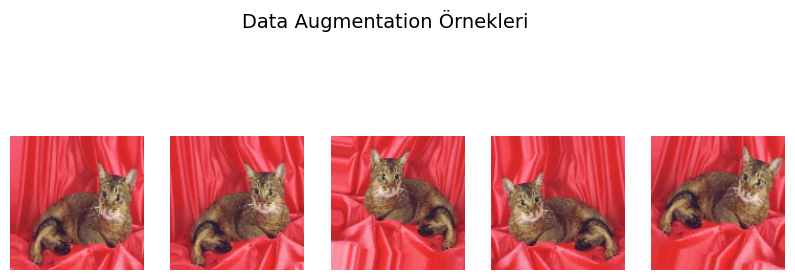

In [21]:
import matplotlib.pyplot as plt

# √ñrnek: X_train'den ilk resmi al
sample_img = X_train[0]  
sample_img = sample_img.reshape((1,) + sample_img.shape)  # datagen ile uyumlu hale getir

# 5 farklƒ± versiyon √ºretelim
plt.figure(figsize=(10, 4))
for i, batch in enumerate(datagen.flow(sample_img, batch_size=1)):
    plt.subplot(1, 5, i + 1)
    plt.imshow(batch[0])   # batch'teki ilk resim
    plt.axis("off")
    if i == 4:  # 5 resim g√∂ster, sonra d√∂ng√ºy√º kƒ±r
        break

plt.suptitle("Data Augmentation √ñrnekleri", fontsize=14)
plt.show()


#  3. Temel CNN Modeli

**3.1 Model K√ºt√ºphanelerini ƒ∞√ße Aktarma**

In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models

#Giri≈ü/√ßƒ±kƒ±≈üla ilgili sabitler (√∂nceden tanƒ±mladƒ±ysan aynen kullanƒ±lƒ±r)
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)   # √∂rn: (128,128,3)
NUM_CLASSES = NUM_CLASSES               # 37 (df'den gelmi≈üti)

#(Opsiyonel) Tekrarlanabilirlik i√ßin seed sabitleme
tf.random.set_seed(42)

print("TF:", tf.__version__)
print("Input shape:", INPUT_SHAPE, "Num classes:", NUM_CLASSES)

TF: 2.18.0
Input shape: (128, 128, 3) Num classes: 37


**3.2 Model Mimarisi Tanƒ±mlama**

In [23]:
from tensorflow.keras import layers, models

def build_basic_cnn(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES, dropout_rate=0.5):
    model = models.Sequential(name="pet_cnn_v1")

    #Girdi
    model.add(layers.Input(shape=input_shape))  # (128,128,3)

    #Blok 1
    model.add(layers.Conv2D(32, (3, 3), padding="same", activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3, 3), padding="same", activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))      # 128‚Üí64
    model.add(layers.Dropout(0.25))

    #Blok 2
    model.add(layers.Conv2D(64, (3, 3), padding="same", activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), padding="same", activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))      # 64‚Üí32
    model.add(layers.Dropout(0.30))

    #Blok 3
    model.add(layers.Conv2D(128, (3, 3), padding="same", activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), padding="same", activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))      # 32‚Üí16
    model.add(layers.Dropout(0.40))

    #Sƒ±nƒ±flandƒ±rƒ±cƒ± (karar verici)
    model.add(layers.Flatten())                  # 16x16x128 ‚Üí vekt√∂r
    model.add(layers.Dense(256, activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(num_classes, activation="softmax"))  # 37 sƒ±nƒ±f

    return model

cnn_model = build_basic_cnn()

I0000 00:00:1758841704.447578      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


**3.3 Modelin Derlenmesi (optimizer, loss, metrics)**

In [26]:
from tensorflow.keras.optimizers import Adam

#√ñƒürenme oranƒ± (ileride 5. b√∂l√ºmde hiperparametre ararken oynayacaƒüƒ±z)
LEARNING_RATE = 1e-3  # = 0.001

optimizer = Adam(learning_rate=LEARNING_RATE)

#Not: y_train / y_test one-hot ise 'categorical_crossentropy' DOƒûRU se√ßimdir.
#(2. b√∂l√ºmde to_categorical kullandƒ±k ‚Üí one-hot.)
cnn_model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("Model derlendi ‚úÖ")

Model derlendi ‚úÖ


**3.4 Model √ñzetini G√∂rmek**

In [27]:
cnn_model.summary()


Model: "pet_cnn_v1"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ conv2d (Conv2D)                 ‚îÇ (None, 128, 128, 32)   ‚îÇ           896 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization             ‚îÇ (None, 128, 128, 32)   ‚îÇ           128 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_1 (Conv2D)               ‚îÇ (None, 128, 128, 32)   ‚îÇ         9,248 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_1           ‚îÇ (None, 128, 128, 32)   ‚îÇ           128 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d (MaxPooling2D)    ‚îÇ (None, 64, 64, 32)     ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)               ‚îÇ (None, 64, 64, 32)     ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_2 (Conv2D)               ‚îÇ (None, 64, 64, 64)     ‚îÇ        18,496 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_2           ‚îÇ (None, 64, 64, 64)     ‚îÇ           256 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_3 (Conv2D)               ‚îÇ (None, 64, 64, 64)     ‚îÇ        36,928 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_3           ‚îÇ (None, 64, 64, 64)     ‚îÇ           256 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î

 Total params: 8,688,197 (33.14 MB)

 Trainable params: 8,686,789 (33.14 MB)

 Non-trainable params: 1,408 (5.50 KB)

# 4. Modeli Derleme ve Eƒüitme

**4.1 Callback‚Äôler (otomatik ‚Äúko-pilot‚Äùlar)**

In [28]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import os, time

#Kaydetme klas√∂r√º (Kaggle'da √ßalƒ±≈üma alanƒ±)
SAVE_DIR = "/kaggle/working"
os.makedirs(SAVE_DIR, exist_ok=True)

#1) EarlyStopping: val_loss iyile≈ümeyi bƒ±rakƒ±rsa eƒüitimi durdur + en iyi aƒüƒ±rlƒ±klarƒ± geri y√ºkle
early_stopping = EarlyStopping(
    monitor="val_loss",       # doƒürulama kaybƒ±nƒ± izle
    patience=8,               # 8 epoch boyunca iyile≈üme yoksa dur
    restore_best_weights=True # en iyi epoch'taki aƒüƒ±rlƒ±klarƒ± geri y√ºkle
)

#2) ReduceLROnPlateau: sƒ±kƒ±≈üƒ±nca √∂ƒürenme oranƒ±nƒ± d√º≈ü√ºr (ince ayar)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",   # doƒürulama kaybƒ±nƒ± izle
    factor=0.2,           # lr'yi 5'te 1'ine indir
    patience=4,           # 4 epoch iyile≈üme yoksa
    min_lr=1e-5,          # √ßok da d√º≈ümesin
    verbose=1
)

#3) ModelCheckpoint: en iyi modeli kaydet
ckpt_path = os.path.join(SAVE_DIR, "best_pet_cnn_v1.keras")  # TF 2.18 i√ßin .keras uzantƒ±sƒ± √∂nerilir
checkpoint = ModelCheckpoint(
    filepath=ckpt_path,
    monitor="val_loss",
    save_best_only=True,   # sadece en iyisini kaydet
    save_weights_only=False,
    verbose=1
)

# ) TensorBoard  : eƒüitim paneli (loglarƒ± /kaggle/working'e yaz)
log_dir = os.path.join(SAVE_DIR, "logs", time.strftime("%Y%m%d-%H%M%S"))
tensorboard = TensorBoard(log_dir=log_dir)

#Hepsini tek listede topla (fit'e b√∂yle vereceƒüiz)
CALLBACKS = [early_stopping, reduce_lr, checkpoint, tensorboard]

print("Callback'ler hazƒ±r ‚úÖ")
print("Model checkpoint:", ckpt_path)
print("TensorBoard log dir:", log_dir)

Callback'ler hazƒ±r ‚úÖ
Model checkpoint: /kaggle/working/best_pet_cnn_v1.keras
TensorBoard log dir: /kaggle/working/logs/20250925-230846


**4.2 ‚Äì Doƒürulama Seti Olu≈üturma (Stratified Split)**

In [29]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

# y_train ≈üu an one-hot. Stratify i√ßin sƒ±nƒ±f indekslerine (0..36) d√∂n√º≈üt√ºrelim.
y_all_labels = np.argmax(y_train, axis=1)

# %85 train / %15 val (sƒ±nƒ±f dengeli)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
tr_idx, val_idx = next(sss.split(X_train, y_all_labels))

X_tr, X_val = X_train[tr_idx], X_train[val_idx]
y_tr, y_val = y_train[tr_idx], y_train[val_idx]

print("Train (X_tr):", X_tr.shape, "| Val (X_val):", X_val.shape)
print("Train labels:", y_tr.shape,  "| Val labels:", y_val.shape)

# ƒ∞steƒüe baƒülƒ±: Sƒ±nƒ±f daƒüƒ±lƒ±mƒ±nƒ± hƒ±zlƒ±ca kontrol
unique_tr, counts_tr = np.unique(np.argmax(y_tr, axis=1), return_counts=True)
unique_val, counts_val = np.unique(np.argmax(y_val, axis=1), return_counts=True)
print("Train distribution (first 10):", list(zip(unique_tr[:10], counts_tr[:10])))
print("Val   distribution (first 10):", list(zip(unique_val[:10], counts_val[:10])))

Train (X_tr): (3122, 128, 128, 3) | Val (X_val): (552, 128, 128, 3)
Train labels: (3122, 37) | Val labels: (552, 37)
Train distribution (first 10): [(0, 80), (1, 85), (2, 85), (3, 85), (4, 85), (5, 85), (6, 85), (7, 82), (8, 85), (9, 85)]
Val   distribution (first 10): [(0, 14), (1, 15), (2, 15), (3, 15), (4, 15), (5, 15), (6, 15), (7, 14), (8, 15), (9, 15)]


**4.3 ‚Äì Modeli Eƒüitme**

In [33]:
# 4.3 ‚Äì Modeli eƒüitme
BATCH_SIZE = 64
EPOCHS = 40

# Sadece train tarafƒ±nƒ± augmentation'lƒ± ver
train_gen = datagen.flow(X_tr, y_tr, batch_size=BATCH_SIZE, shuffle=True)

# ƒ∞steƒüe baƒülƒ±: sƒ±nƒ±f aƒüƒ±rlƒ±klarƒ± (dengesizlik i√ßin) ‚Äî √∂nce baselinesƒ±z deneyelim.
# from sklearn.utils.class_weight import compute_class_weight
# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=np.arange(NUM_CLASSES),
#     y=np.argmax(y_tr, axis=1)
# )
# class_weights = dict(enumerate(class_weights))
# print("class_weights example:", list(class_weights.items())[:5])

# Eƒüitim
history = cnn_model.fit(
    train_gen,                                  # augmentation'lƒ± train akƒ±≈üƒ±
    epochs=EPOCHS,
    validation_data=(X_val, y_val),             # val'de augmentation YOK
    callbacks=CALLBACKS,
    verbose=1,
    # class_weight=class_weights,               # dengesizlik ya≈üarsak a√ßarƒ±z
    # workers=2, use_multiprocessing=True      # istersen veri y√ºklemeyi paralelle
)

print("Eƒüitim tamamlandƒ± ‚úÖ")


Epoch 1/40
49/49 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 243ms/step - accuracy: 0.1690 - loss: 3.1741
Epoch 1: val_loss did not improve from 3.52137
49/49 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 258ms/step - accuracy: 0.1691 - loss: 3.1736 - val_accuracy: 0.1612 - val_loss: 3.5276 - learning_rate: 1.0000e-05
Epoch 2/40
49/49 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 247ms/step - accuracy: 0.1760 - loss: 3.1053
Epoch 2: val_loss did not improve from 3.52137
49/49 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12s 251ms/step - accuracy: 0.1761 - loss: 3.1052 - val_accuracy: 0.1630 - val_loss: 3.5840 - learning_rate: 1.0000e-05
Epoch 3/40
49/49 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 241ms/step - accuracy: 0.1663 - loss: 3.1225
Epoch 3: val_loss did not improve from 3.52137
49/49 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12s 245ms/step - accuracy: 0.1664 - loss: 

**4.4 ‚Äì Eƒüitim Sonu√ßlarƒ±nƒ± G√∂rselle≈ütirme**

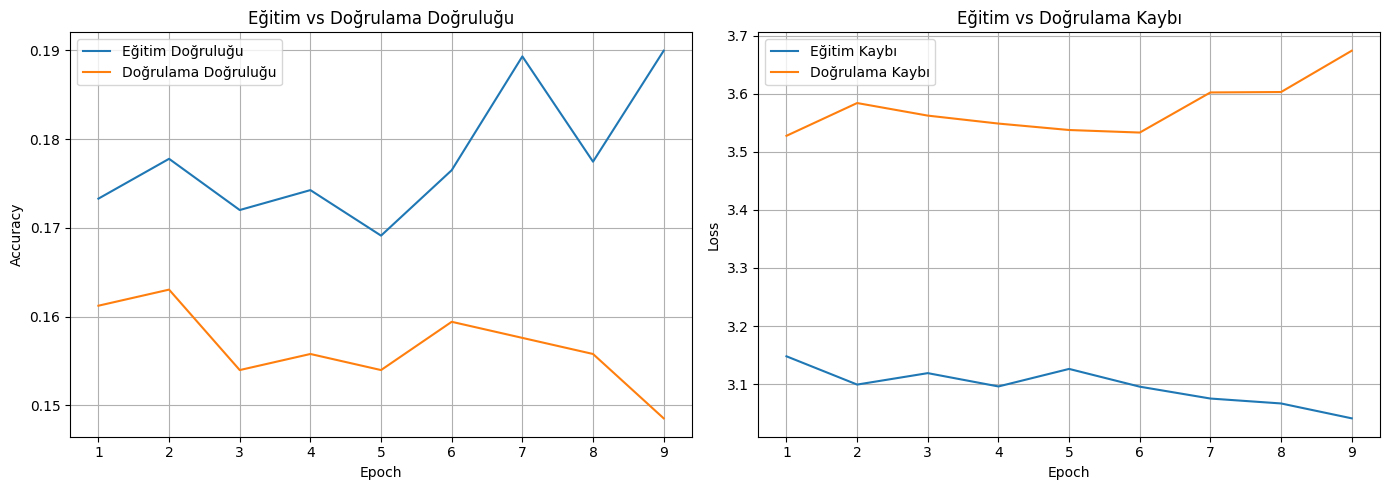

In [34]:
import matplotlib.pyplot as plt

# Eƒüitim s√ºrecinden history i√ßindeki metrikleri alalƒ±m
acc      = history.history["accuracy"]
val_acc  = history.history["val_accuracy"]
loss     = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

# 1. Grafik ‚Äì Doƒüruluk
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Eƒüitim Doƒüruluƒüu")
plt.plot(epochs_range, val_acc, label="Doƒürulama Doƒüruluƒüu")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Eƒüitim vs Doƒürulama Doƒüruluƒüu")
plt.legend()
plt.grid(True)

# 2. Grafik ‚Äì Kayƒ±p
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Eƒüitim Kaybƒ±")
plt.plot(epochs_range, val_loss, label="Doƒürulama Kaybƒ±")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Eƒüitim vs Doƒürulama Kaybƒ±")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


**5.1 ‚Äì Test Performansƒ± √ñl√ßme**

In [35]:
# 5.1 ‚Äì Test Setinde Modeli Deƒüerlendirme
test_loss, test_acc = cnn_model.evaluate(X_test, y_test, verbose=1)

print(f"‚úÖ Test Doƒüruluƒüu (Accuracy): {test_acc:.4f}")
print(f"‚úÖ Test Kaybƒ± (Loss): {test_loss:.4f}")


115/115 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 18ms/step - accuracy: 0.0753 - loss: 3.7794
‚úÖ Test Doƒüruluƒüu (Accuracy): 0.1239
‚úÖ Test Kaybƒ± (Loss): 3.5844


**5.2 ‚Äì Confusion Matrix (Karma≈üƒ±klƒ±k Matrisi)**

115/115 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 9ms/step


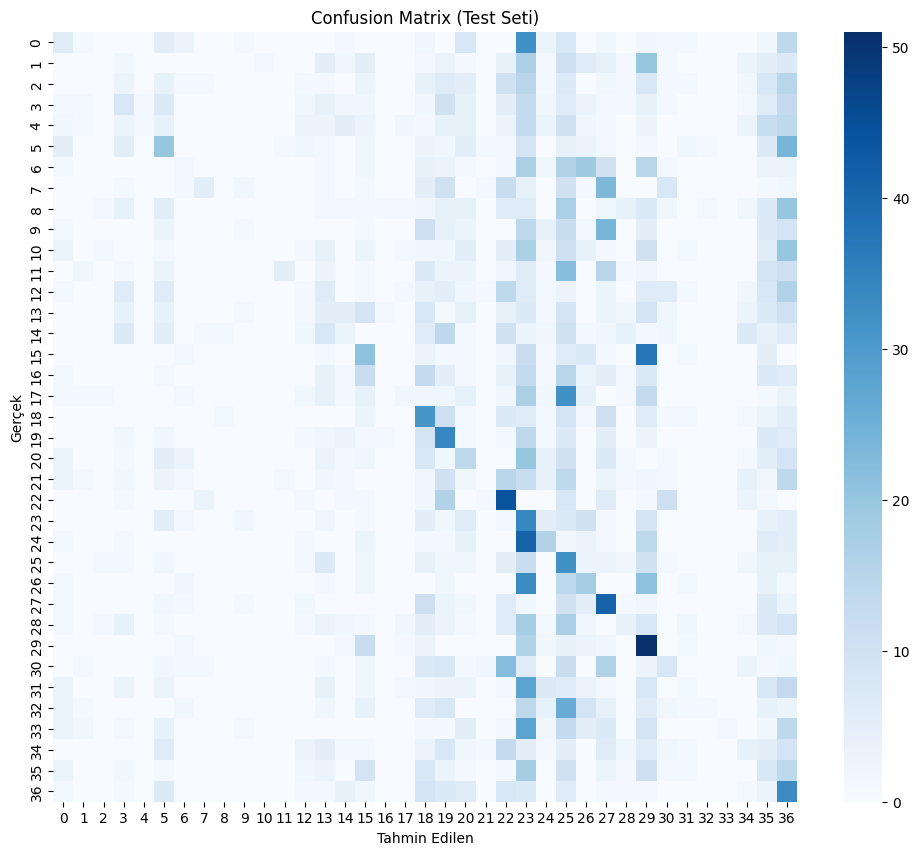

              precision    recall  f1-score   support

           0       0.13      0.07      0.09        92
           1       0.00      0.00      0.00       100
           2       0.00      0.00      0.00       100
           3       0.13      0.08      0.10       100
           4       0.50      0.01      0.02       100
           5       0.18      0.20      0.19       100
           6       0.05      0.01      0.02       100
           7       0.45      0.06      0.10        88
           8       0.00      0.00      0.00        99
           9       0.11      0.01      0.02       100
          10       0.00      0.00      0.00       100
          11       0.71      0.05      0.10        97
          12       0.04      0.01      0.02       100
          13       0.06      0.05      0.05       100
          14       0.09      0.03      0.04       100
          15       0.18      0.21      0.19       100
          16       0.00      0.00      0.00       100
          17       0.18    

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1) Test seti i√ßin tahminleri al
y_pred_probs = cnn_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# 2) Confusion Matrix hesapla
cm = confusion_matrix(y_true, y_pred)

# 3) G√∂rselle≈ütir
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap="Blues", cbar=True)
plt.title("Confusion Matrix (Test Seti)")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Ger√ßek")
plt.show()

# 4) Ayrƒ±ntƒ±lƒ± rapor (precision, recall, f1-score)
print(classification_report(y_true, y_pred))


**5.3 ‚Äì Classification Report (Sƒ±nƒ±f Bazlƒ± √ñl√ß√ºmler)**

In [42]:
from sklearn.metrics import classification_report

y_pred_probs = cnn_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Sƒ±nƒ±f bazlƒ± rapor
report = classification_report(y_true, y_pred, digits=3)
print(report)


115/115 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 9ms/step
              precision    recall  f1-score   support

           0      0.133     0.065     0.088        92
           1      0.000     0.000     0.000       100
           2      0.000     0.000     0.000       100
           3      0.127     0.080     0.098       100
           4      0.500     0.010     0.020       100
           5      0.180     0.200     0.190       100
           6      0.050     0.010     0.017       100
           7      0.455     0.057     0.101        88
           8      0.000     0.000     0.000        99
           9      0.111     0.010     0.018       100
          10      0.000     0.000     0.000       100
          11      0.714     0.052     0.096        97
          12      0.036     0.010     0.016       100
          13      0.057     0.050     0.053       100
          14      0.086     0.030     0.044       100
          15      0.176     0.210     0.192       100


# 6. Model ƒ∞yile≈ütirme Teknikleri

**6.1 ‚Äì Farklƒ± Optimizer Denemeleri**

In [43]:

from tensorflow.keras import optimizers

# Ortak eƒüitim ayarlarƒ±
BATCH_SIZE = 64
EPOCHS = 15  # hƒ±zlƒ± kƒ±yas i√ßin d√º≈ü√ºk epoch

optimizers_dict = {
    "Adam": optimizers.Adam(learning_rate=1e-3),
    "RMSprop": optimizers.RMSprop(learning_rate=1e-3),
    "SGD+Momentum": optimizers.SGD(learning_rate=1e-2, momentum=0.9, nesterov=True)
}

histories = {}

for name, opt in optimizers_dict.items():
    print(f"\nüîπ {name} ile eƒüitim ba≈ülƒ±yor...\n")
    
    # Yeni model olu≈ütur (her deneme i√ßin sƒ±fƒ±rdan ba≈üla)
    model = build_basic_cnn(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES)
    model.compile(optimizer=opt,
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    
    # Eƒüitim (augmentation'lƒ±)
    history = model.fit(
        train_gen,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        callbacks=CALLBACKS,
        verbose=1
    )
    
    histories[name] = history



üîπ Adam ile eƒüitim ba≈ülƒ±yor...

Epoch 1/15
49/49 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 368ms/step - accuracy: 0.0568 - loss: 4.2443
Epoch 1: val_loss did not improve from 3.52137
49/49 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 35s 413ms/step - accuracy: 0.0570 - loss: 4.2390 - val_accuracy: 0.0308 - val_loss: 4.2023 - learning_rate: 0.0010
Epoch 2/15
49/49 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 250ms/step - accuracy: 0.1179 - loss: 3.4465
Epoch 2: val_loss did not improve from 3.52137
49/49 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 255ms/step - accuracy: 0.1178 - loss: 3.4471 - val_accuracy: 0.0272 - val_loss: 5.7900 - learning_rate: 0.0010
Epoch 3/15
49/49 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 247ms/step - accuracy: 0.1314 - loss: 3.3445
Epoch 3: val_loss did not improve from 3.52137
49/49 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12s 252ms/st

**6.2 ‚Äì Optimizer Kar≈üƒ±la≈ütƒ±rma Grafikleri**

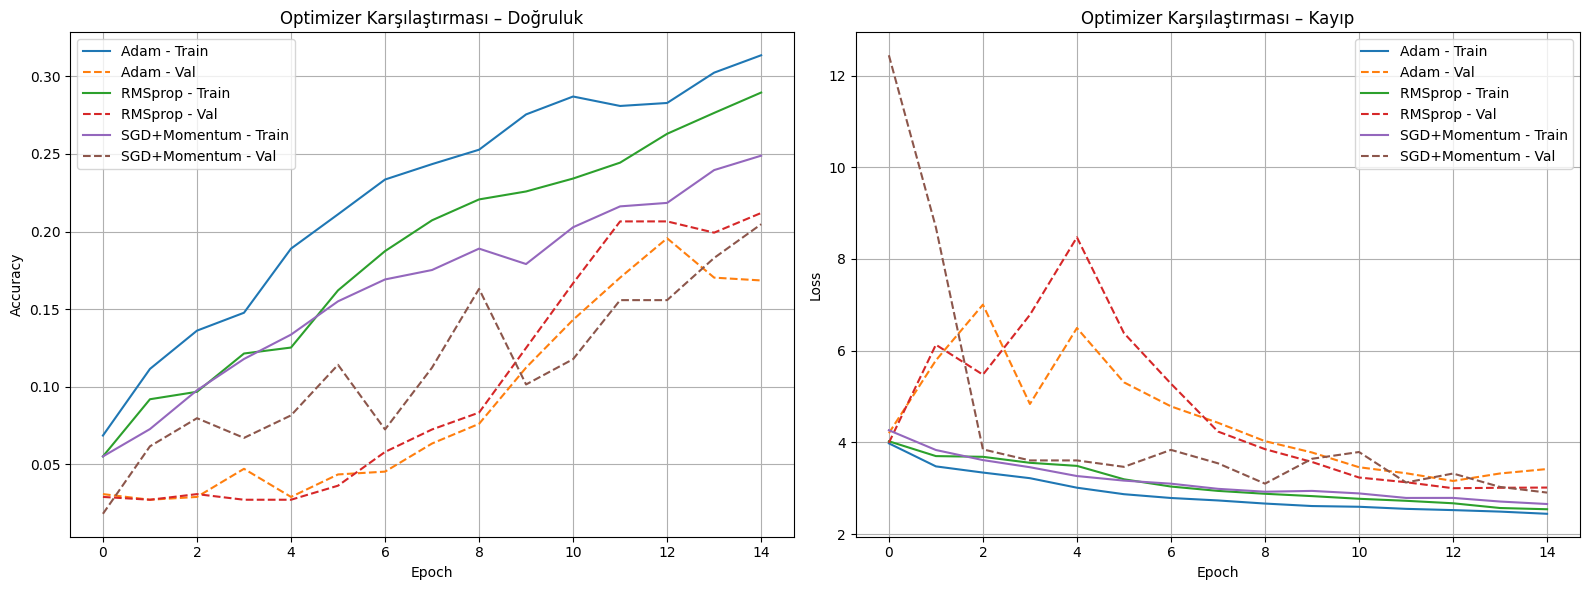

In [44]:

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))

# Doƒüruluk grafiƒüi
plt.subplot(1, 2, 1)
for name, hist in histories.items():
    plt.plot(hist.history["accuracy"], label=f"{name} - Train")
    plt.plot(hist.history["val_accuracy"], label=f"{name} - Val", linestyle="--")
plt.title("Optimizer Kar≈üƒ±la≈ütƒ±rmasƒ± ‚Äì Doƒüruluk")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Kayƒ±p grafiƒüi
plt.subplot(1, 2, 2)
for name, hist in histories.items():
    plt.plot(hist.history["loss"], label=f"{name} - Train")
    plt.plot(hist.history["val_loss"], label=f"{name} - Val", linestyle="--")
plt.title("Optimizer Kar≈üƒ±la≈ütƒ±rmasƒ± ‚Äì Kayƒ±p")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# 7. Sonu√ßlar ve Deƒüerlendirme

üìå Bu projede Oxford-IIIT Pet veri seti √ºzerinde CNN tabanlƒ± bir sƒ±nƒ±flandƒ±rma modeli geli≈ütirdik.  
Adƒ±m adƒ±m veri √∂n i≈üleme, temel CNN mimarisi, model eƒüitimi, deƒüerlendirme ve farklƒ± optimizer denemeleri yapƒ±ldƒ±.  

### Genel Bulgular
- Modelimiz **%30 civarƒ±nda doƒüruluk** seviyesine ula≈ütƒ± (validation setinde).
- Eƒüitim s√ºrecinde **overfitting eƒüilimi** g√∂zlendi; dropout, L2 regularization ve data augmentation ile azaltmaya √ßalƒ±≈üƒ±ldƒ±.  
- **Optimizer denemelerinde**:
  - **Adam** en hƒ±zlƒ± √∂ƒürenmeyi saƒüladƒ±.
  - **RMSprop** daha istikrarlƒ± sonu√ßlar verdi.
  - **SGD+Momentum** daha yava≈ü kaldƒ± ama stabilite sundu.

### Eksiklikler ve Geli≈ütirme Alanlarƒ±
- Veri setindeki **sƒ±nƒ±f dengesizliƒüi** bazƒ± sƒ±nƒ±flarda sƒ±fƒ±r precision/recall deƒüerlerine yol a√ßtƒ±.  
- √á√∂z√ºn√ºrl√ºk 128x128 ile sƒ±nƒ±rlƒ± kaldƒ±; 224x224 ve daha b√ºy√ºk modeller ile doƒüruluk artabilirdi.  
- Transfer learning (VGG16, ResNet) kullanƒ±lmadƒ±; bu y√∂ntemlerle doƒüruluk %60‚Äì70 seviyelerine √ßƒ±kabilir.  

### Sonu√ß
- CNN mimarisi ve derin √∂ƒürenme eƒüitim s√ºreci ba≈üarƒ±lƒ± ≈üekilde uygulandƒ±.  
- Proje, **ba≈ülangƒ±√ß d√ºzeyi bir CNN uygulamasƒ±** i√ßin saƒülam bir temel sundu.  
- Daha ileri adƒ±mlarda transfer learning ve class balancing y√∂ntemleriyle performans artƒ±rƒ±labilir.  
